In [1]:
import os
import sys
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvelo as scv
from pathlib import Path
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn import metrics
from scipy.sparse import csr_matrix
import multiprocessing as mp

from GraphCVAE import run, GraphCVAE

# Set environment variable for CUDA device
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/anaconda3/envs/deepst_env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
data_path = "/data/GraphCVAE copy/data/DLPFC/" #### to yo ur path
data_name = "151673" #### project name
save_path = "/data/GraphCVAE copy/Results" #### save path
file_fold = str(data_path) + str(data_name) #please replace 'file_fold' with the download path

In [3]:
deepen = run(save_path = save_path,
	use_gpu = True)
###### Read in 10x Visium data, or user can read in themselves.
adata = deepen._get_adata(platform="Visium", data_path=data_path, data_name=data_name)
###### Segment the Morphological Image
adata = deepen._get_image_crop(adata, data_name=data_name) 

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]  


In [4]:
adata = deepen._get_augment(adata, spatial_type="KDTree", use_morphological=True)


Physical distance calculting Done!
The number of nearest tie neighbors in physical distance is: 30.0
Gene correlation calculting Done!
Morphological similarity calculting Done!
The weight result of image feature is added to adata.obsm['weights_matrix_all'] !


Find adjacent spots of each spot: 100%|██████████ [ time left: 00:00 ]


Step 1: Augment molecule expression is Done!


In [5]:
augment_sparse = csr_matrix(adata.obsm['augment_gene_data'])
adata.X = augment_sparse+adata.X


In [8]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/usr/lib/R'

In [9]:
n_clusters =  7


In [10]:
adata_aug=adata

In [11]:
# define model
model = GraphCVAE(adata_aug, device=device,epochs=1200)

# train model
adata_aug = model.train()

  0%|          | 2/1200 [00:00<01:29, 13.45it/s]

Begin to train ST data...


100%|██████████| 1200/1200 [01:27<00:00, 13.77it/s]


Optimization finished for ST data!


In [12]:
# set radius to specify the number of neighbors considered during refinement
radius =30
tool = 'mclust' # mclust, leiden, and louvain
# clustering
from utils import clustering
if tool == 'mclust':
   clustering(adata_aug, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata_aug, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]: Package 'mclust' version 6.1
Type 'citation("mclust")' for citing this R package in publications.



In [13]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata_aug.obs['ground_truth'] = df_meta_layer.values

In [14]:
# filter out NA nodes
adata_aug = adata_aug[~pd.isnull(adata_aug.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata_aug.obs['domain'], adata_aug.obs['ground_truth'])
adata_aug.uns['ARI'] = ARI

print('Dataset:', data_name)
print('ARI:', ARI)

Dataset: 151673
ARI: 0.6605767548363802


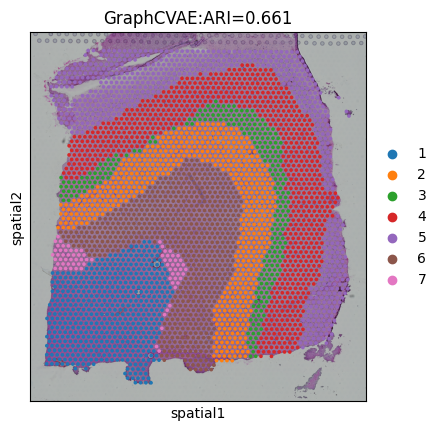

In [15]:
# plotting spatial clustering result
sc.pl.spatial(adata_aug,
              img_key="hires",
              color=["domain"],
              title=["GraphCVAE:ARI=%.3f"%ARI],
              show=True,)